Distributed Cross Validated Parameter Search
------------------------------------

In the previous section we parallelized cross-validated parameter search on a single machine.  In this notebook we do the same exercise, but now on a distributed cluster.  

### Requirements

This notebook should be run on the provided cluster.

### Application

We train a machine learning model across many parameters with cross validation.  This is slightly more complex than a map so we use `submit`.  We train a support vector classifier on handwritten digits using cross validation to avoid over-fitting.

As before we start with a sequential solution.

### Imports

In [8]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.grid_search import ParameterSampler
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from cv_params_demo import load_cv_split, evaluate_one  # Functions we care about

### Shared Software Environment

We will run into issues if our worker machines lack the `cv_params_demo.py` file holding some of the custom functions necessary for this section.  Distributed computing frameworks have mechanisms to solve this by sending .py files around.  In order to skip dealing with this we're just going to include all of the content of that file in this notebook.  

Run the following cell twice.

In [9]:
# %load cv_params_demo.py
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
from sklearn.externals.joblib import hash
import pandas as pd
import numpy as np

def load_cv_split(split_idx):
    data = load_digits()
    splitted = train_test_split(data.data, data.target,
                                test_size=0.20,
                                random_state=split_idx)
    return split_idx, splitted

def evaluate_one(model_class, parameters, cv_split):
    split_idx, (X_train, X_val, y_train, y_val) = cv_split
    model = model_class(**parameters).fit(X_train, y_train)

    train_score = model.score(X_train, y_train)
    validation_score = model.score(X_val, y_val)

    results = {
        'train_score': train_score,
        'val_score': validation_score,
        'parameters': parameters,
        'parameters_hash': hash(parameters),
    }
    return results

import matplotlib.pyplot as plt

def plot_param_map(df, target, title):
    fig = plt.figure(figsize=(6, 5))
    plt.xlabel('log10(C)')
    plt.ylabel('log10(gamma)')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(np.log10(df['C']), np.log10(df['gamma']),
                c=target,
                marker='s', edgecolors='none',
                s=80, alpha=1, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    return fig

def plot_results(results):
    results = pd.DataFrame.from_dict(results)

    mean_evaluations = results.groupby('parameters_hash').agg({
        'val_score': np.mean,
       # 'training_time': np.mean,
    }).reset_index()

    all_parameters = pd.DataFrame.from_dict(list(results['parameters']))
    all_parameters['parameters_hash'] = results['parameters_hash']

    evaluations = (
        mean_evaluations
        .merge(all_parameters)
        .drop(['parameters_hash'], axis=1)
    )
    top10 = evaluations.sort_values(
        by='val_score', ascending=False).head(10)

    fig = plot_param_map(evaluations, evaluations['val_score'],
                   'validation score')
    plt.scatter(np.log10(top10['C']), np.log10(top10['gamma']),
                c='r', s=50)


### Data

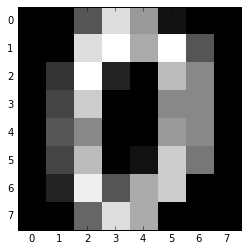

In [10]:
digits = load_digits()  # Collect Data

plt.imshow(digits.data[0].reshape(8, 8),  # Example element
           interpolation='nearest', cmap='gray');

### Parameters

In [11]:
param_grid = {
    'C': np.logspace(-10, 10, 1001),
    'gamma': np.logspace(-10, 10, 1001),
    'tol': np.logspace(-4, -1, 4),
}

param_space = ParameterSampler(param_grid, 10)

list(param_space)

[{'C': 2.29086765276777, 'gamma': 17378.008287493762, 'tol': 0.01},
 {'C': 5.4954087385762481e-05, 'gamma': 3.9810717055349692e-07, 'tol': 0.01},
 {'C': 0.00012589254117941688, 'gamma': 239883291.90194851, 'tol': 0.01},
 {'C': 1380384264.6028867, 'gamma': 4.5708818961487518e-06, 'tol': 0.0001},
 {'C': 9.1201083935590964e-05, 'gamma': 501.18723362727354, 'tol': 0.0001},
 {'C': 0.45708818961487518, 'gamma': 1.9054607179632483e-06, 'tol': 0.0001},
 {'C': 0.00033113112148259143, 'gamma': 0.63095734448019425, 'tol': 0.01},
 {'C': 5495408.7385762706,
  'gamma': 2.1877616239495517e-06,
  'tol': 0.10000000000000001},
 {'C': 52480.746024977336,
  'gamma': 5011872.3362727147,
  'tol': 0.10000000000000001},
 {'C': 0.00075857757502918353, 'gamma': 60.255958607435687, 'tol': 0.001}]

### Split data for cross-validation

In [12]:
from cv_params_demo import load_cv_split

cv_splits = [load_cv_split(i) for i in range(2)]
idx, (x_train, x_test, y_train, y_test) = cv_splits[0]
x_train, y_train

(array([[  0.,   0.,   0., ...,  16.,  16.,   6.],
        [  0.,   3.,  12., ...,  16.,   2.,   0.],
        [  0.,   1.,  10., ...,   0.,   0.,   0.],
        ..., 
        [  0.,   0.,   5., ...,   0.,   0.,   0.],
        [  0.,   0.,   4., ...,   0.,   0.,   0.],
        [  0.,   0.,   6., ...,  11.,   0.,   0.]]),
 array([6, 5, 3, ..., 7, 7, 8]))

### Sequential cross validated parameter search

In [13]:
%%time

results = []

for split in cv_splits:
    for params in param_space:
        result = evaluate_one(SVC, params, split)
        results.append(result)

CPU times: user 15.2 s, sys: 4 ms, total: 15.2 s
Wall time: 15.3 s


### Plot results

Which regions of parameter space score well?  Can we tell from the results we've computed?  

Searching over more parameters would help to improve the intuition we can gain here.

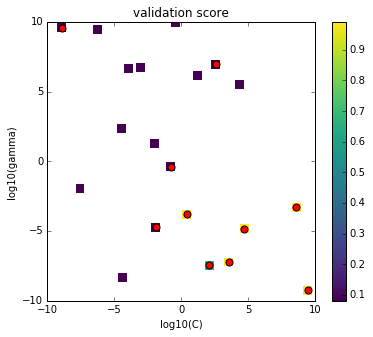

In [14]:
from cv_params_demo import plot_results

plot_results(results)

### Exercise: Distributed parallel cross validated parameter search

We will use both Spark or Dask.distributed to scale our computation across multiple machines.

In [15]:
cv_splits = [load_cv_split(i) for i in range(2)]  # Increase the number 2 after parallel computation acheived
param_space = ParameterSampler(param_grid, 10)    # Increase the number 10 after parallel computation acheived

### Concurrent.futures solution

We load the solution using `concurrent.futures`.  Then we replace the stdlib `concurrent.futures.ThreadPoolExecutor` with an API compatible executor from either `ipyparallel` or `dask.distributed`.

In [ ]:
%load solutions/cvgs-1.py

In [ ]:
plot_results(results)

### Spark Solution

We load the single-machine solution using the local Spark instance `'local[4]'`.  We replace this SparkContext with a new SparkContext pointing to the cluster instead.

In [ ]:
%load solutions/cvgs-2.py

In [ ]:
plot_results(results)